### League of Legends - Predicting win based on first 10 minutes of the game

##### 🔧 Import libraries, set up 🔧

In [37]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style('darkgrid')

##### ⬆️ Load, set up and split the data set ⬆️

In [38]:
df = pd.read_csv('data/high_diamond_ranked_10min.csv')
display(df.head())

df = df.drop('gameId', axis=1) #removing gameId as it is not useful for prediction

Y = df['blueWins'] #target variable
X = df.drop('blueWins', axis=1) #features

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1) 

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


##### 🛁 Clean the data 🛁

In [39]:
display(df.corr()["blueWins"].abs().sort_values(ascending=False))

# Strong correlation between Total and per minute
display(df[["blueTotalGold", "blueGoldPerMin"]].corr())

# EliteMonsters = Dragons + Heralds
df["check_sum"] = df["blueDragons"] + df["blueHeralds"]
display(df[["check_sum", "blueEliteMonsters"]].corr())
df.drop("check_sum", axis=1, inplace=True) #removing check_sum as it is redundant

blueWins                        1.000000
redGoldDiff                     0.511119
blueGoldDiff                    0.511119
blueExperienceDiff              0.489558
redExperienceDiff               0.489558
blueTotalGold                   0.417213
blueGoldPerMin                  0.417213
redTotalGold                    0.411396
redGoldPerMin                   0.411396
blueTotalExperience             0.396141
redTotalExperience              0.387588
blueAvgLevel                    0.357820
redAvgLevel                     0.352127
redKills                        0.339297
blueDeaths                      0.339297
blueKills                       0.337358
redDeaths                       0.337358
blueAssists                     0.276685
redAssists                      0.271047
blueCSPerMin                    0.224909
blueTotalMinionsKilled          0.224909
blueEliteMonsters               0.221944
redEliteMonsters                0.221551
blueDragons                     0.213768
redTotalMinionsK

,blueTotalGold,blueGoldPerMin
blueTotalGold,1.0,1.0
blueGoldPerMin,1.0,1.0


,check_sum,blueEliteMonsters
check_sum,1.0,1.0
blueEliteMonsters,1.0,1.0


In [40]:
df.corr()["blueWins"].abs().sort_values(ascending=False)

to_drop = ['redGoldDiff', 'redExperienceDiff', 'blueEliteMonsters', 'redEliteMonsters',
           'blueGoldPerMin', 'redGoldPerMin', 'blueCSPerMin', 'redCSPerMin',
           'redDeaths', 'redKills', 'redFirstBlood', 
           ]

df_cleaned = df.drop(to_drop, axis=1)
display(df_cleaned.head())

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redWardsDestroyed,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,...,6,8,0,0,0,16567,6.8,17047,197,55
1,0,12,1,0,5,5,5,0,0,0,...,1,2,1,1,1,17620,6.8,17438,240,52
2,0,15,0,0,7,11,4,1,0,0,...,3,14,0,0,0,17285,6.8,17254,203,28
3,0,43,1,0,4,5,5,0,1,0,...,2,10,0,0,0,16478,7.0,17961,235,47
4,0,75,4,0,6,6,6,0,0,0,...,2,7,1,0,0,17404,7.0,18313,225,67


##### 💉 Feature engineering 💉

In [41]:
diff_vars = ['TotalGold', 'TotalExperience', 'AvgLevel', 'Kills', 
             'Deaths', 'Assists', 'TotalMinionsKilled', 'Dragons', 
             'Heralds', 'WardsPlaced', 'WardsDestroyed', 'TowersDestroyed',
             'TotalJungleMinionsKilled']

df_fe = pd.DataFrame()
for var in diff_vars:
    df_fe[f'{var}Diff'] = df[f'blue{var}'] - df[f'red{var}']

df_fe['blueWins'] = df['blueWins']
df_fe['blueFirstBlood'] = df['blueFirstBlood']

In [42]:
# Compare correlations of blue, red and diff variables with blueWins
corr_table = pd.DataFrame()

# Calculate blue and red correlations with blueWins
for var in diff_vars:
    blue_col = f'blue{var}'
    red_col = f'red{var}'
    blue_corr = df[blue_col].corr(df['blueWins']) if blue_col in df.columns else np.nan
    red_corr = df[red_col].corr(df['blueWins']) if red_col in df.columns else np.nan
    diff_corr = df_fe[f'{var}Diff'].corr(df_fe['blueWins']) if f'{var}Diff' in df_fe.columns else np.nan
    corr_table = pd.concat([corr_table, pd.DataFrame({
        'Variable': [var],
        'Blue Corr': [blue_corr],
        'Red Corr': [red_corr],
        'Diff Corr': [diff_corr]
    })], ignore_index=True)

corr_table['Is Diff Corr Better?'] = (
    corr_table['Diff Corr'].abs() > corr_table[['Blue Corr', 'Red Corr']].abs().max(axis=1)
)

display(corr_table)

,Variable,Blue Corr,Red Corr,Diff Corr,Is Diff Corr Better?
0,TotalGold,0.417213,-0.411396,0.511119,True
1,TotalExperience,0.396141,-0.387588,0.489558,True
2,AvgLevel,0.357820,-0.352127,0.452927,True
3,Kills,0.337358,-0.339297,0.479379,True
4,Deaths,-0.339297,0.337358,-0.479379,True
5,Assists,0.276685,-0.271047,0.385866,True
6,TotalMinionsKilled,0.224909,-0.212171,0.309126,True
7,Dragons,0.213768,-0.209516,0.234264,True
8,Heralds,0.092385,-0.097172,0.121713,True
9,WardsPlaced,0.000087,-0.023671,0.016890,False


##### 🌲 Decision tree 🌲

In [43]:
# --- Decision Tree ---
decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_train, Y_train)
y_pred_dt = decision_tree.predict(X_test)
accuracy_dt = accuracy_score(Y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)
for x in range(1, 11):
    decision_tree = DecisionTreeClassifier(max_depth=x, random_state=1)
    decision_tree.fit(X_train, Y_train)
    y_pred_dt = decision_tree.predict(X_test)
    accuracy_dt = accuracy_score(Y_test, y_pred_dt)
    print(f"Decision Tree Accuracy with max_depth={x}:", accuracy_dt)

Decision Tree Accuracy: 0.6421052631578947
Decision Tree Accuracy with max_depth=1: 0.7327935222672065
Decision Tree Accuracy with max_depth=2: 0.7327935222672065
Decision Tree Accuracy with max_depth=3: 0.7327935222672065
Decision Tree Accuracy with max_depth=4: 0.725506072874494
Decision Tree Accuracy with max_depth=5: 0.7137651821862349
Decision Tree Accuracy with max_depth=6: 0.7125506072874493
Decision Tree Accuracy with max_depth=7: 0.7101214574898785
Decision Tree Accuracy with max_depth=8: 0.702834008097166
Decision Tree Accuracy with max_depth=9: 0.7093117408906883
Decision Tree Accuracy with max_depth=10: 0.694331983805668


In [44]:
for x in range(1, 11):
    decision_tree = DecisionTreeClassifier(max_depth=x, random_state=1)
    decision_tree.fit(X_train, Y_train)
    y_pred_dt = decision_tree.predict(X_test)
    accuracy_dt = accuracy_score(Y_test, y_pred_dt)
    print(f"Decision Tree Accuracy with max_depth={x}:", accuracy_dt)

Decision Tree Accuracy with max_depth=1: 0.7327935222672065
Decision Tree Accuracy with max_depth=2: 0.7327935222672065
Decision Tree Accuracy with max_depth=3: 0.7327935222672065
Decision Tree Accuracy with max_depth=4: 0.725506072874494
Decision Tree Accuracy with max_depth=5: 0.7137651821862349
Decision Tree Accuracy with max_depth=6: 0.7125506072874493
Decision Tree Accuracy with max_depth=7: 0.7101214574898785
Decision Tree Accuracy with max_depth=8: 0.702834008097166
Decision Tree Accuracy with max_depth=9: 0.7093117408906883
Decision Tree Accuracy with max_depth=10: 0.694331983805668


In [45]:
dt_new = DecisionTreeClassifier(max_depth=3, random_state=1)
dt_new.fit(X_train, Y_train)
y_pred_dt = dt_new.predict(X_test)
accuracy_dt = accuracy_score(Y_test, y_pred_dt)
print("Decision Tree Accuracy with max_depth=3:", accuracy_dt)

Decision Tree Accuracy with max_depth=3: 0.7327935222672065


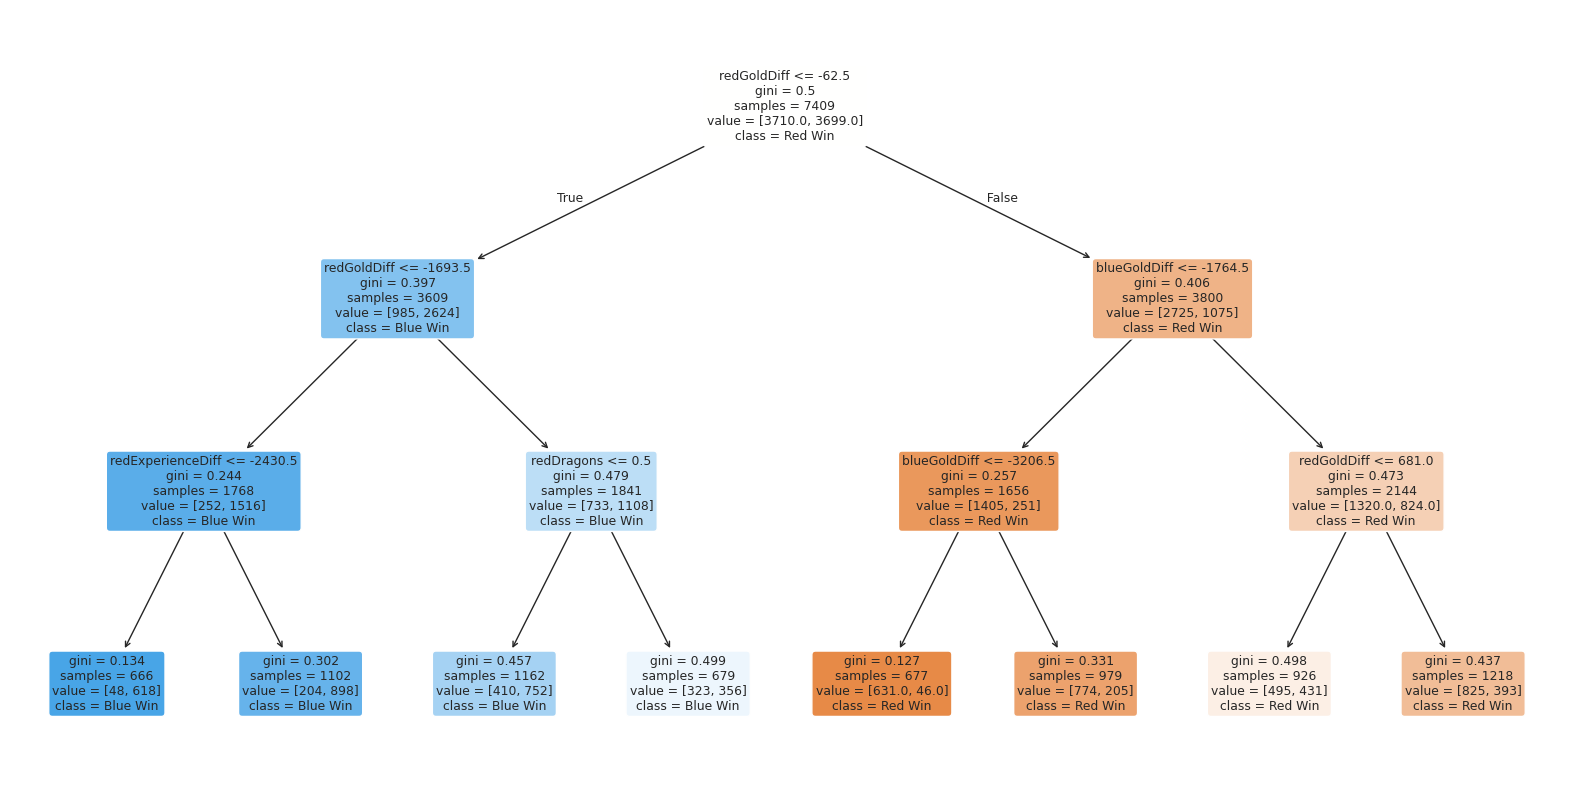

In [46]:
# Tree visualization
plt.figure(figsize=(20,10))
tree.plot_tree(dt_new, feature_names=X.columns, class_names=['Red Win', 'Blue Win'], filled=True, rounded=True)
plt.show()

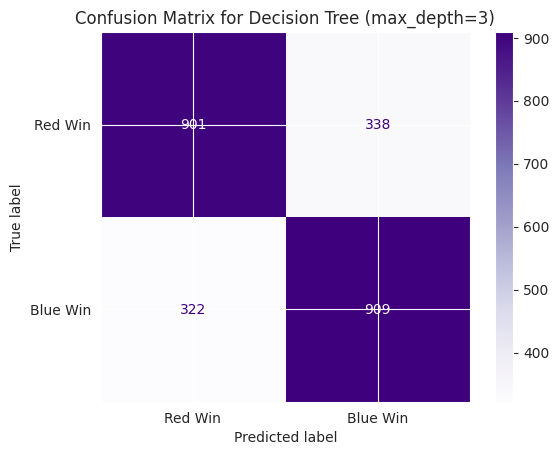

In [47]:
# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Win', 'Blue Win'])
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix for Decision Tree (max_depth=3)")
plt.show()

##### 🌳🌳 Random forest 🌳🌳

In [48]:
# --- Random Forest ---
random_forest = RandomForestClassifier(random_state=1)
random_forest.fit(X_train, Y_train)
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(Y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.7275303643724697


In [54]:
# XGBoost
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=1)
xgb_clf.fit(X_train, Y_train)
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(Y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Accuracy: 0.7093117408906883


In [50]:
# Logistic Regression (ze skalowaniem)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=1, max_iter=1000)
log_reg.fit(X_train_scaled, Y_train)
y_pred_log = log_reg.predict(X_test_scaled)
accuracy_log = accuracy_score(Y_test, y_pred_log)
print("Logistic Regression Accuracy:", accuracy_log)

Logistic Regression Accuracy: 0.7437246963562752


# TODO
- Test everything on df, df_clean and df_fe
- Tune some parameters in every model